In [4]:
import pandas as pd
import numpy as np
import csv

df = pd.read_csv('nasdaq/AppleInc.csv', index_col = 'Date', parse_dates=True)
iter_len = len(df['Close'])
filename = 'Apple.csv'


# Labeling: increase = 1, decrease = -1

with open(filename, 'w', newline='') as f:
    wt = csv.writer(f)
    wt.writerow("avg1, avg2".split(","))
    #wt.writerow("Date,Open,High,Low,Close,Adj Close,Volume,Label".split(","))
    for i in range(iter_len-1):
        line1 = df.iloc[i]
        line2 = df.iloc[i+1]
        a1 = (line1['Open']+line1['High']+line1['Low']+line1['Close'])/4
        a2 = (line2['Open']+line2['High']+line2['Low']+line2['Close'])/4
        wt.writerow([a1,a2])

<AxesSubplot:title={'center':'Apple Inc. OHLC avg'}>

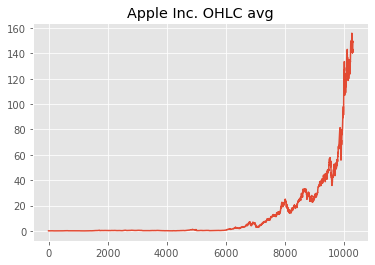

In [6]:
import matplotlib.pyplot as plt
df = pd.read_csv('Apple.csv')
plt.style.use('ggplot')
df['avg1'].plot(label='CLOSE', title='Apple Inc. OHLC avg')

In [7]:
X = df.iloc[:, 0]
y = df.iloc[:, 1] 

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = mm.fit_transform(X)
y_mm = mm.fit_transform(y)

ValueError: Expected 2D array, got 1D array instead:
array=[1.28487494e-01 1.21931002e-01 1.13001999e-01 ... 1.48577496e+02
 1.49625000e+02 1.49107502e+02].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [37]:
X_train = X_ss[:9000, :]
X_test = X_ss[9000:, :]

y_train = y_mm[:9000, :]
y_test = y_mm[9000:, :] 

In [38]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (9000, 6) (9000, 1)
Testing Shape (1307, 6) (1307, 1)


In [39]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [40]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [41]:
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [42]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [43]:
num_epochs = 10000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 2 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [44]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 

In [45]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [46]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

C:\Users\juni\anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([9000, 1])) that is different to the input size (torch.Size([9000, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, loss: nan
Epoch: 100, loss: nan
Epoch: 200, loss: nan


KeyboardInterrupt: 

In [31]:
df_X_ss = ss.transform(df.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(df.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

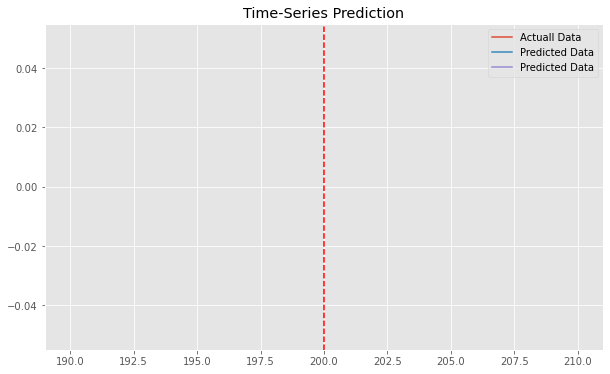

In [32]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 